In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from batchbald_redux.joint_entropy import ExactJointEntropy

from entropy import calculate_entropy, calculate_conditional_entropy
from utils import get_mixture_prob_dist, nested_to_tensor, CandidateBatch

First, generate fake model outputs of shape `(N, K, C)`, where
- `N` is the number of unlabeled data, 
- `K` is the number of inference samples (meaning different weights sampled from the posterior distribution),
- and `C` is the number of classes. 

In [2]:
# number of inference samples
K = 20

In [3]:
p1 = [0.7, 0.1, 0.1, 0.1]
p2 = [0.4, 0.3, 0.2, 0.1]
y1_ws = np.asarray([get_mixture_prob_dist(p1, p2, m) for m in np.linspace(0, 1, K)])
# the most certain sample

p1 = [0.1, 0.7, 0.1, 0.1]
p2 = [0.2, 0.3, 0.3, 0.2]
y2_ws = np.asarray([get_mixture_prob_dist(p1, p2, m) for m in np.linspace(0, 1, K)])

p1 = [0.1, 0.1, 0.7, 0.1]
p2 = [0.25, 0.25, 0.25, 0.25]
y3_ws = np.asarray([get_mixture_prob_dist(p1, p2, m) for m in np.linspace(0, 1, K)])

p1 = [0.15, 0.1, 0.25, 0.5]
p2 = [0.4, 0.3, 0.2, 0.1]
y4_ws = np.asarray([get_mixture_prob_dist(p1, p2, m) for m in np.linspace(0, 1, K)])
# the most uncertain sample

ys_ws = nested_to_tensor([y1_ws, y2_ws, y3_ws, y4_ws])
ys_ws.shape

torch.Size([4, 20, 4])

We can visualize the fake inputs as shown below. 

The input #0 is the most certain one, and the input #3 is the least certain one. 

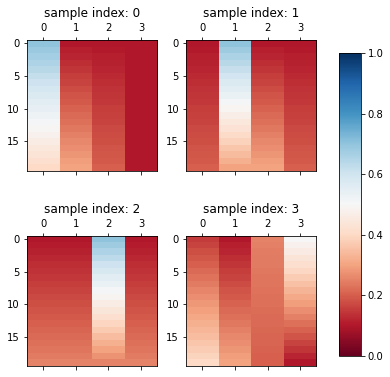

In [4]:
cmap = plt.get_cmap("RdBu")

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for idx, ax in enumerate(axes.flat):
    im = ax.matshow(ys_ws[idx], aspect=0.2, vmin=0, vmax=1, cmap=cmap)
    ax.set_title(f"sample index: {idx}")
fig.subplots_adjust(right=0.8, hspace=0.5)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

Calculating entropies and conditional entropies of a batch sample is implemented in `entropy.py`. 

We can calculate the joint entropy by

$$
\begin{aligned}
H[y_{1:b}] &= E_y[-\log p(y_{1:b})] = E_w \left[E_{y|w}[-\log p(y_{1:b} | w)] \right] \\
&= E_w \left[ E_{y|w} [-\log E_w [p(y_{1:b} | w)] ] \right] \\
&\approx -\sum_{\hat y_{1:b}} \left\{ \left( {1 \over k} \sum_{j=1}^{k} p(\hat y_{1:b} | \hat w_j) \right) \cdot 
\log \left( {1 \over k} \sum_{j=1}^{k} p(\hat y_{1:b} | \hat w_j) \right) \right\}
\end{aligned}
$$

And we can also calculate the conditional entropy by 

$$
\begin{aligned}
H[y_{1:b}|w] &= E_w H[y_{1:b}|w] = \sum_w p(w) H[y_{1:b} | w] \\
&\approx - {1 \over k} \sum_{j=1}^{k} \sum_{y_{1:b}} \left\{ p(\hat y_{1:b}|\hat w_j) \cdot \log p(\hat y_{\hat 1:b}|\hat w_j) \right\}
\end{aligned}
$$

In [5]:
calculate_entropy(ys_ws.log().double())

tensor([1.1655, 1.2376, 1.2687, 1.3737], dtype=torch.float64)

In [6]:
calculate_conditional_entropy(ys_ws.log().double())

tensor([1.1453, 1.2069, 1.2304, 1.3270], dtype=torch.float64)

In [7]:
calculate_entropy(ys_ws.log().double()) - calculate_conditional_entropy(ys_ws.log().double())

tensor([0.0202, 0.0307, 0.0383, 0.0467], dtype=torch.float64)

We can naively implement `get_batchbald` and `get_bald`.

In [10]:
def get_batchbald(
    log_probs: torch.Tensor, batch_size: int = 128, max_N: int = 1024
) -> CandidateBatch:
    if log_probs.ndim != 3:
        raise ValueError()

    N, K, C = log_probs.shape

    candidate = CandidateBatch([], [])
    not_in_candidate = list(range(N))

    for b in range(batch_size):

        scores = torch.zeros((N,), dtype=torch.double, device=log_probs.device)
        if b > 0:
            _indices = torch.tensor(
                candidate.indices, device=log_probs.device, dtype=torch.long
            )
            scores.index_fill_(0, _indices, -1e9)
            # the lowest score possible

        for idx in not_in_candidate:
            _indices = candidate.indices + [idx]
            # print(_indices)
            _log_probs = log_probs[_indices, :, :]
            # print(_log_probs)

            scores[idx] += calculate_entropy(_log_probs, max_N).sum()
            scores[idx] -= calculate_conditional_entropy(_log_probs, max_N).mean()

        max_score, max_index = scores.max(dim=0)

        candidate.scores.append(max_score.item())
        candidate.indices.append(max_index.item())

        not_in_candidate.remove(max_index)

    return candidate

In [11]:
get_batchbald(ys_ws.log().double(), 2, 2)

CandidateBatch(scores=[0.04669819630358063, 1.3636951542992395], indices=[3, 2])

In [12]:
def get_bald(
    log_probs: torch.Tensor, batch_size: int, max_N: int = 1024
) -> CandidateBatch:
    N, K, C = log_probs.shape

    batch_size = min(batch_size, N)

    candidate_indices = []
    candidate_scores = []

    scores_N = -calculate_conditional_entropy(log_probs, max_N)
    scores_N += calculate_entropy(log_probs, max_N)

    candidate_scores, candidate_indices = torch.topk(scores_N, batch_size)

    return CandidateBatch(candidate_scores.tolist(), candidate_indices.tolist())

In [13]:
get_bald(ys_ws.log().double(), 2, 2)

CandidateBatch(scores=[0.04669819630358063, 0.038301580617693176], indices=[3, 2])

In [14]:
joint_entropy = ExactJointEntropy.empty(K, dtype=torch.double)
entropy = joint_entropy.add_variables(ys_ws[:4].log()).compute()

In [15]:
entropy

tensor(5.0337, dtype=torch.float64)

In [17]:
calculate_entropy(ys_ws.log().double()).sum()

tensor(5.0455, dtype=torch.float64)